In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown (see cell below)
# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2



# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

# paperspace only
#!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *

from spanda.data.transforms import (SpectraBlock, AnalytesBlock,
                                    RandWAvgTfm, NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
# List dataset
path = Path('../../_data/kssl-mirs-v2'); path.ls()

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

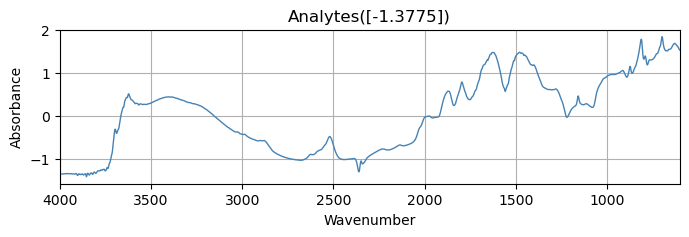

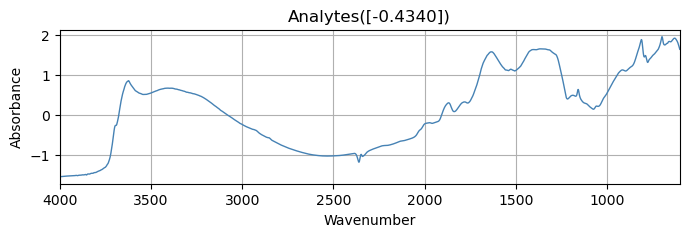

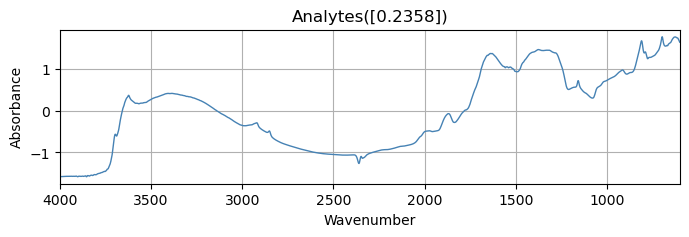

In [ ]:
get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d', fname.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[725])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), NormalizeTfm(mean=0.8813, std=0.4324),
                              LogTfm()])

dls = dblock.dataloaders(path.ls()[:1000], bs=3)
dls.show_batch()

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.lr_find()

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
# Select only positive values
t = AnalytesTfm(analytes=[725])
paths = L([p for p in path.ls() if t(p) > 0]); paths

(#44619) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
# Create Data loader
dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[725])),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandWAvgTfm(), NormalizeTfm(mean=0.8813, std=0.4324),
                              LogTfm()])

dls = dblock.dataloaders(paths[100:300], bs=16)

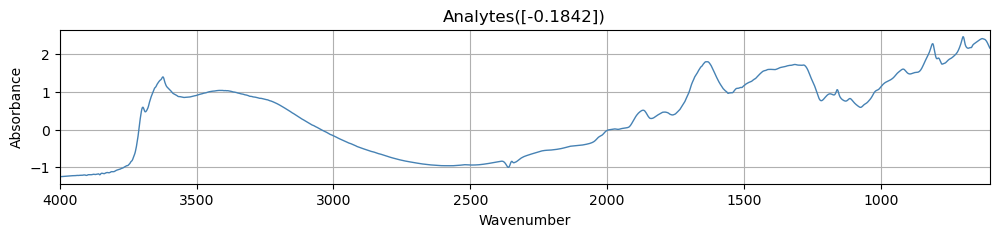

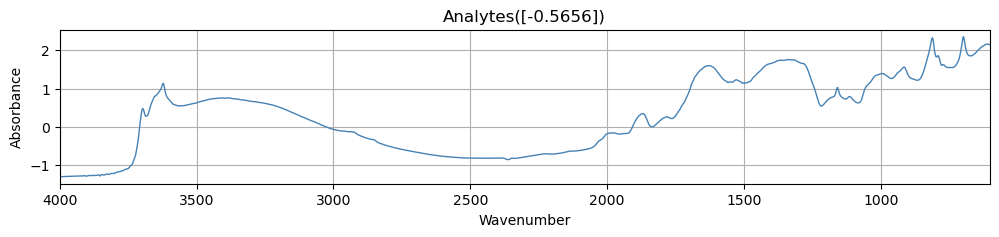

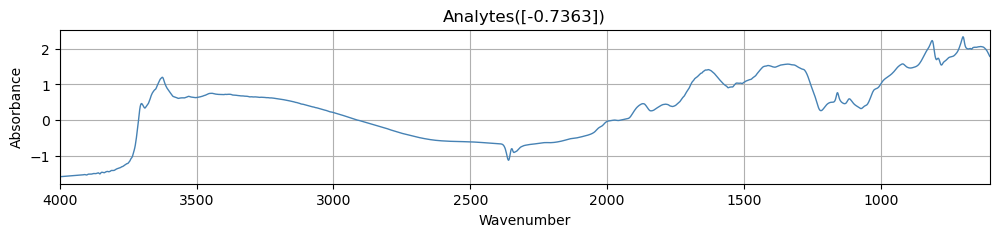

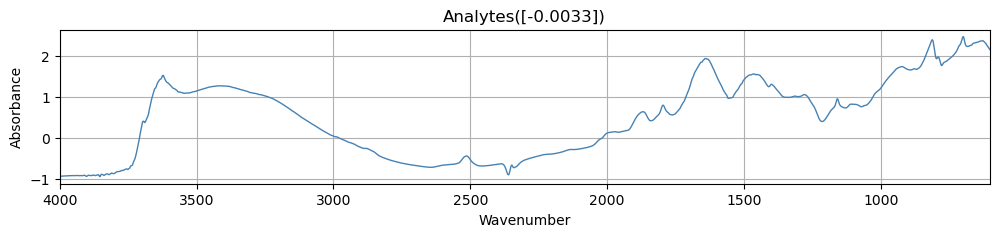

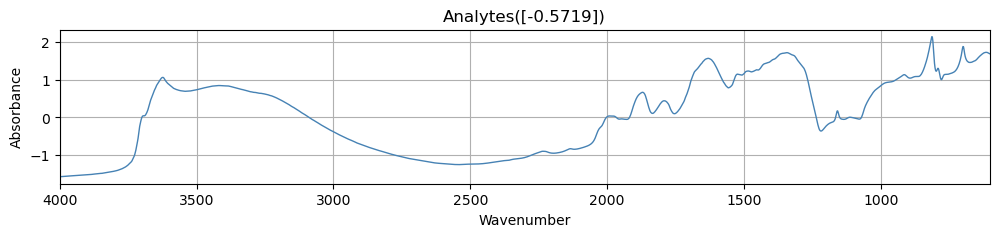

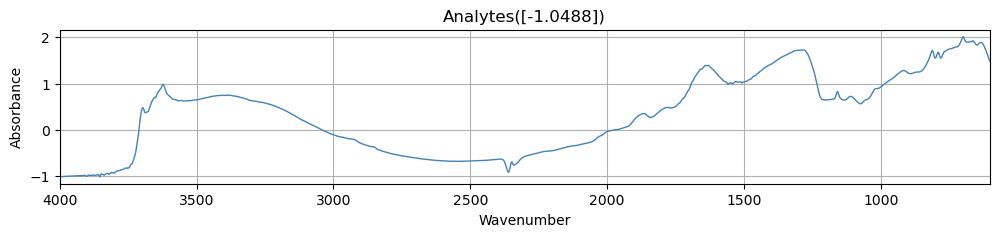

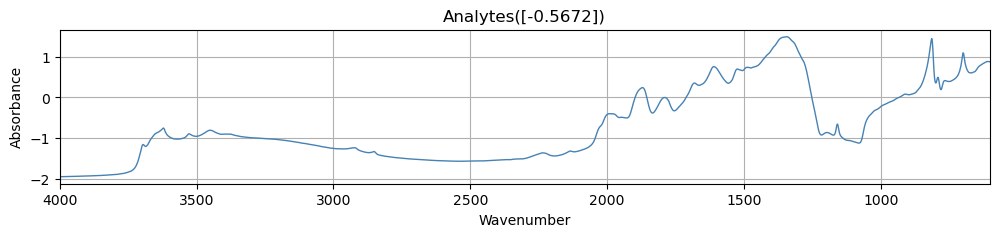

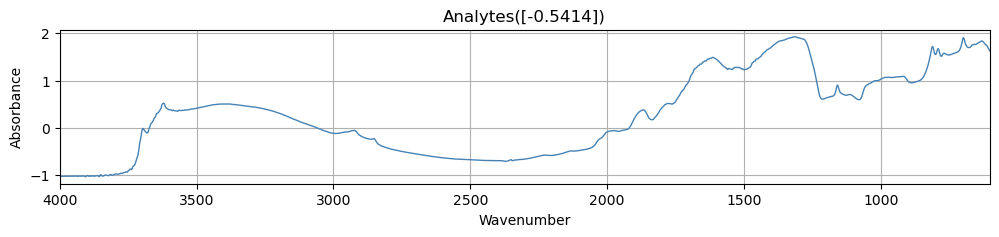

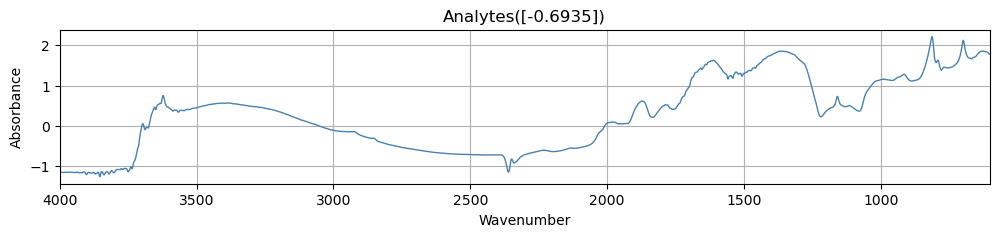

In [ ]:
dls.valid.show_batch()

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.summary()

XResNet (Input shape: 16 x 1 x 1700)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 850       
Conv1d                                    96         True      
BatchNorm1d                               64         True      
ReLU                                                           
Conv1d                                    3072       True      
BatchNorm1d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 850       
Conv1d                                    6144       True      
BatchNorm1d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 425       
MaxPool1d                                  

SuggestedLRs(valley=0.0002290867705596611)

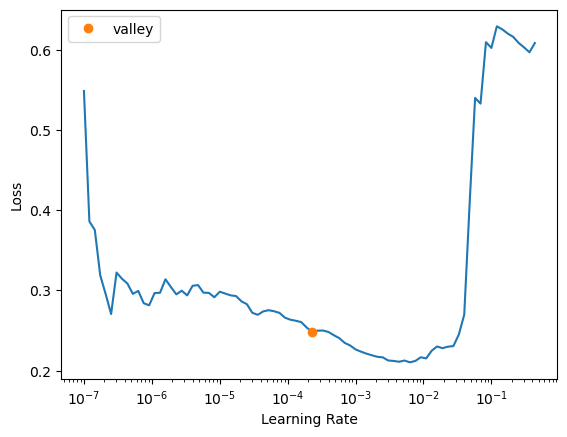

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.256093,0.385704,-1.919293,00:12
1,0.230480,0.234638,-0.775918,00:12
2,0.223700,0.269099,-1.036738,00:12
3,0.216937,0.280089,-1.119922,00:12
4,0.213318,0.283002,-1.141972,00:14
5,0.202253,0.178689,-0.352454,00:13
6,0.199199,0.369520,-1.796802,00:14
7,0.200216,0.162810,-0.232271,00:12
8,0.198222,0.129879,0.016977,00:12
9,0.193582,0.110780,0.161536,00:13


In [ ]:
#learn.save('xresnet18-v2-80-epochs-k-ex-snv-lr-1e-3-r2-0.84')

Path('models/xresnet18-v2-80-epochs-k-ex-snv-lr-1e-3-r2-0.84.pth.pth')